<a href="https://colab.research.google.com/github/UditGupta10/DistAdam/blob/master/Dist_Adam.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import numpy as np
import sys
import matplotlib.pyplot as plt
#np.random.seed(42)

In [0]:
size=2**26
np.random.seed(0)
grad_org1 = np.random.uniform(-2,3,size=size)
np.random.seed(42)
grad_org2 = np.random.uniform(-2,3,size=size)

#For sparse gradients, use these arrays instead of above
# np.random.seed(0)
# grad_org1 = np.random.choice(np.asarray([-1,0,1]), size=size, p=[0.1, 0.7, 0.2])
# np.random.seed(42)
# grad_org2 = np.random.choice(np.asarray([-1,0,1]), size=size, p=[0.1, 0.7, 0.2])


eta = 0.001
beta1=0.9
beta2=0.999
epsilon = 10**(-1)
procs = 32                  # Number of workers
mb_small = 2**10            # Small batch size
mb_large = mb_small * procs # Large batch size

#parameters corresponding to small batch size
grad = np.zeros(size//mb_small + 1)
m = np.zeros(size//mb_small + 1)
v = np.zeros(size//mb_small + 1)
alpha = np.zeros(size//mb_small + 1)
val = np.zeros(size//mb_small + 1)

#parameters corresponding to large batch size (distributed case; parameters for small batches computed simultaneously by 'procs' workers)
grad_hat = np.zeros(size//mb_large + 1)
m_hat = np.zeros(size//mb_large + 1)
v_hat = np.zeros(size//mb_large + 1)
alpha_hat = np.zeros(size//mb_large + 1)
val_hat = np.zeros(size//mb_large + 1)

m_hat_prime = np.zeros(size//mb_large + 1)
v_hat_prime = np.zeros(size//mb_large + 1)
val_hat_prime = np.zeros(size//mb_large + 1)


#parameters corresponding to large batch size (Computed sequentially from small batches)
m_new = np.zeros(size//mb_large + 1)
v_new = np.zeros(size//mb_large + 1)
alpha_new = np.zeros(size//mb_large + 1)
val_new = np.zeros(size//mb_large + 1)

for t in range(1, size//mb_small + 1):
  temp_g = np.mean(grad_org1[mb_small*(t-1): mb_small*(t-1) + mb_small])
  grad[t] = temp_g
  m[t] = beta1*m[t-1] + (1-beta1)*temp_g
  v[t] = beta2*v[t-1] + (1-beta2)*temp_g**2
  alpha[t] = eta*(np.sqrt(1-beta2**t)/(1-beta1**t))
  val[t] = (alpha[t]*m[t])/(np.sqrt(v[t]) + epsilon)

#reshape to form matrix with second dimension as 'procs'
grad = grad[1:].reshape((-1, procs))
m = m[1:].reshape((-1, procs))
v = v[1:].reshape((-1, procs))
alpha = alpha[1:].reshape((-1, procs))
val = val[1:].reshape((-1, procs))

#beta1^procs is proposed in DistAdam. Default is just beta1.
#Default is given by '_hat', distadam is given by '_hat_prime'
for t in range(1, size//mb_large + 1):
  temp_g = np.mean(grad_org2[mb_large*(t-1): mb_large*(t-1) + mb_large])
  grad_hat[t] = temp_g
  m_hat[t] = (beta1)*m_hat[t-1] + (1-beta1)*temp_g
  v_hat[t] = (beta2)*v_hat[t-1] + (1-beta2)*(temp_g**2)
  alpha_hat[t] = eta*(np.sqrt(1-beta2**t)/(1-beta1**t))
  val_hat[t] = (alpha_hat[t]*m_hat[t])/(np.sqrt(v_hat[t]) + epsilon)
  
  m_hat_prime[t] = (beta1**procs)*m_hat_prime[t-1] + (1-beta1**procs)*temp_g
  v_hat_prime[t] = (beta2**procs)*v_hat_prime[t-1] + (1-beta2**procs)*(temp_g**2)
  val_hat_prime[t] = (alpha_hat[t]*m_hat_prime[t])/(np.sqrt(v_hat_prime[t]) + epsilon)

#This is ideal scenario which would happen if small batches were computed sequentially to calculate parameters for large batch.
#It is compared to '_hat' above.
for i in range(1, size//mb_large + 1):
  agg = 0
  for j in range(procs):
    agg += (beta1**(procs-j-1) * np.mean(grad_org2[(i-1)*mb_large + j*mb_small : (i-1)*mb_large + (j+1)*mb_small]))
  m_new[i] = (beta1**procs)*m_new[i-1] + (1-beta1)*agg
for i in range(1, size//mb_large + 1):
  agg = 0
  for j in range(procs):
    agg += (beta2**(procs-j-1) * (np.mean(grad_org2[(i-1)*mb_large + j*mb_small : (i-1)*mb_large + (j+1)*mb_small]))**2)
  v_new[i] = (beta2**procs)*v_new[i-1] + (1-beta2)*agg
for t in range(1, size//mb_large + 1):
  alpha_new[t] = eta*(np.sqrt(1-beta2**t)/(1-beta1**t))
  val_new[t] = (alpha_new[t]*m_new[t])/(np.sqrt(v_new[t]) + epsilon)

grad_hat = grad_hat[1:].reshape((-1, 1))
m_hat = m_hat[1:].reshape((-1, 1))
v_hat = v_hat[1:].reshape((-1, 1))
alpha_hat = alpha_hat[1:].reshape((-1, 1))
val_hat = val_hat[1:].reshape((-1, 1))

m_hat_prime = m_hat_prime[1:].reshape((-1, 1))
v_hat_prime = v_hat_prime[1:].reshape((-1, 1))
val_hat_prime = val_hat_prime[1:].reshape((-1, 1))

m_new = m_new[1:].reshape((-1, 1))
v_new = v_new[1:].reshape((-1, 1))
alpha_new = alpha_new[1:].reshape((-1, 1))
val_new = val_new[1:].reshape((-1, 1))

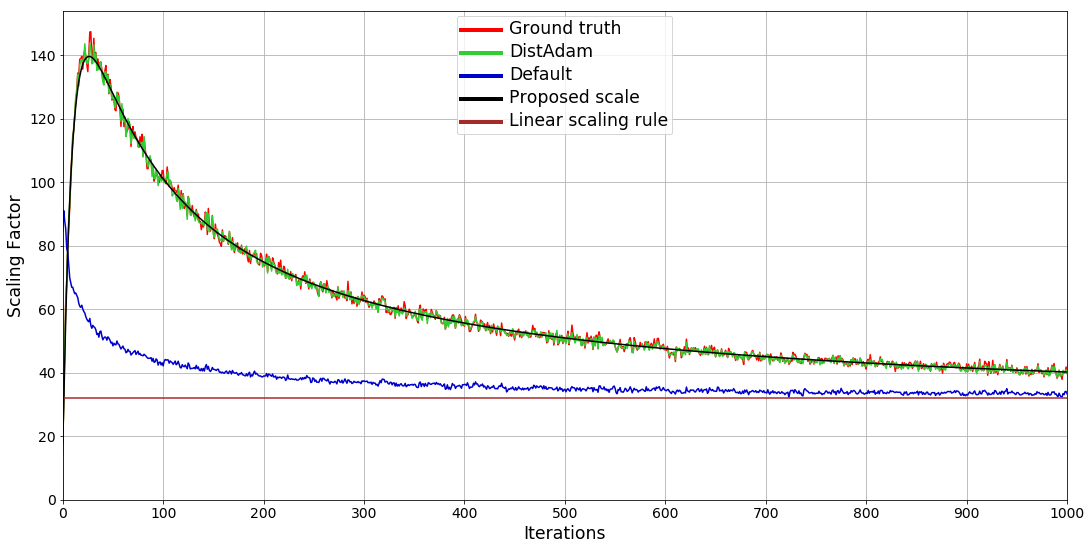

In [4]:
scale = []
for t in range(1,1001):
    agg = [(np.sqrt(1-beta2**i)/(1-beta1**i)) for i in range(procs*t, procs*(t-1), -1)]
    np_agg = np.asarray(agg)
    one_shot = (np.sqrt(1-beta2**t)/(1-beta1**t))
    scale.append((np.sum(np_agg))/one_shot)
    #scale.append(np.log(np.sum(np.exp(np_agg)))/one_shot)
scale = np.asarray(scale)
# print('{}, {}, {}'.format(size, np.max(scale), np.argmax(scale)))
# plt.plot(scale)
fig, ax1 = plt.subplots(1,1, figsize=(18,9))
ax1.plot((np.sum(val, axis=1).reshape((-1,1))/val_new), label='Ground truth',color='red')
ax1.plot((np.sum(val, axis=1).reshape((-1,1))/val_hat_prime), label='DistAdam',color='limegreen')
ax1.plot((np.sum(val, axis=1).reshape((-1,1))/val_hat), label='Default',color='mediumblue')

ax1.plot(scale, label='Proposed scale',color='black')
ax1.axhline(y=procs, xmax=size//mb_large, label='Linear scaling rule', color='brown')
ax1.set_xlim(0, 1000)
ax1.set_xlabel('Iterations', fontsize = 'xx-large')
ax1.set_ylabel('Scaling Factor', fontsize = 'xx-large')
ax1.set_xticks(np.arange(0, 1001, 100))
ax1.set_yticks(np.arange(0, 151, 20))
for tick in ax1.yaxis.get_major_ticks():
    tick.label.set_fontsize(14)
for tick in ax1.xaxis.get_major_ticks():
    tick.label.set_fontsize(14)
#ax1.set_ylim(0, 20)
leg = ax1.legend(loc='upper center', handlelength=4)
for line in leg.get_lines():
    line.set_linewidth(4)
# get label texts inside legend and set font size
for text in leg.get_texts():
    text.set_fontsize('xx-large')
ax1.grid()
#fig.savefig('distadam_scale1.png')

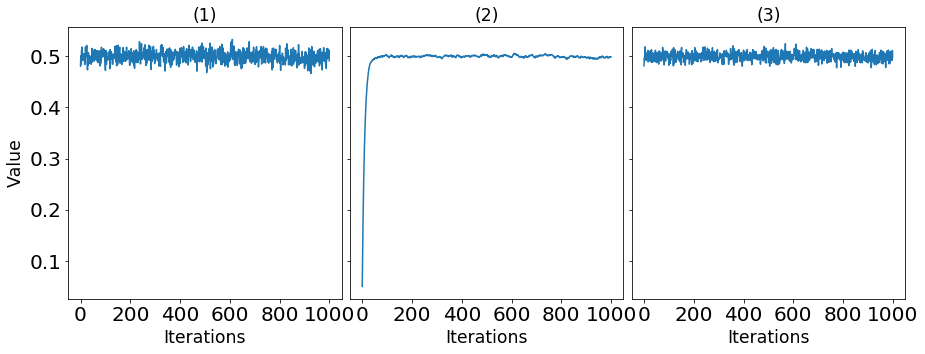

In [12]:
fig, ax = plt.subplots(1,3, figsize=(15,5), sharex=False, sharey='row')
temp = 1000
#ax[0, 0].plot(m[:temp, procs-1])
ax[0].plot(m_new[:temp, 0])
ax[1].plot(m_hat[:temp, 0])
ax[2].plot(m_hat_prime[:temp, 0])

# ax[0].set_title('\'m\' small batch sequential at k intervals')
# ax[1].set_title('\'m\' large batch default')
# ax[2].set_title('\'m\' large batch DistAdam')

ax[0].set_title('(1)', fontsize = 'xx-large')
ax[1].set_title('(2)', fontsize = 'xx-large')
ax[2].set_title('(3)', fontsize = 'xx-large')

ax1.set_xticks(np.arange(0, 1001, 100))

ax[0].set_xlabel('Iterations', fontsize = 'xx-large');
ax[1].set_xlabel('Iterations', fontsize = 'xx-large');
ax[2].set_xlabel('Iterations', fontsize = 'xx-large');

ax[0].set_ylabel('Value', fontsize = 'xx-large');
for axs in ax:
    for tick in axs.yaxis.get_major_ticks():
        tick.label.set_fontsize(20)
    for tick in axs.xaxis.get_major_ticks():
        tick.label.set_fontsize(20)
fig.subplots_adjust(wspace=0.03, hspace=0)

#fig.savefig('distadam_m.png')

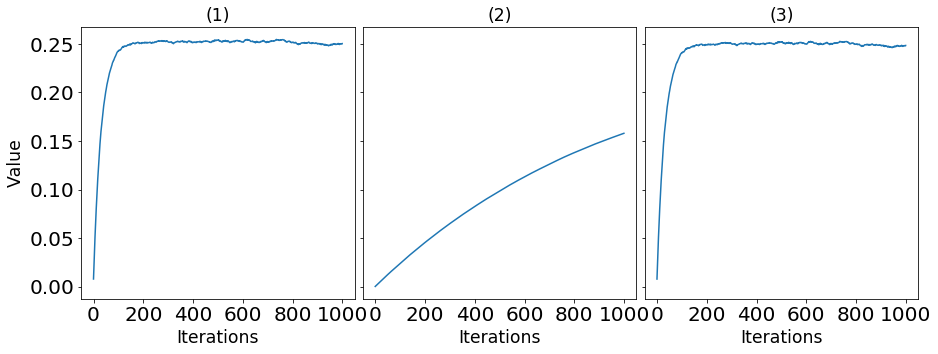

In [11]:
fig, ax = plt.subplots(1,3, figsize=(15,5), sharex=False, sharey='row')
temp = 1000
#ax[0, 0].plot(m[:temp, procs-1])
ax[0].plot(v_new[:temp, 0])
ax[1].plot(v_hat[:temp, 0])
ax[2].plot(v_hat_prime[:temp, 0])

# ax[0].set_title('\'m\' small batch sequential at k intervals')
# ax[1].set_title('\'m\' large batch default')
# ax[2].set_title('\'m\' large batch DistAdam')

ax[0].set_title('(1)', fontsize = 'xx-large')
ax[1].set_title('(2)', fontsize = 'xx-large')
ax[2].set_title('(3)', fontsize = 'xx-large')

ax1.set_xticks(np.arange(0, 1001, 100))

ax[0].set_xlabel('Iterations', fontsize = 'xx-large');
ax[1].set_xlabel('Iterations', fontsize = 'xx-large');
ax[2].set_xlabel('Iterations', fontsize = 'xx-large');

ax[0].set_ylabel('Value', fontsize = 'xx-large');
for axs in ax:
    for tick in axs.yaxis.get_major_ticks():
        tick.label.set_fontsize(20)
    for tick in axs.xaxis.get_major_ticks():
        tick.label.set_fontsize(20)
fig.subplots_adjust(wspace=0.03, hspace=0)

#fig.savefig('distadam_v.png')

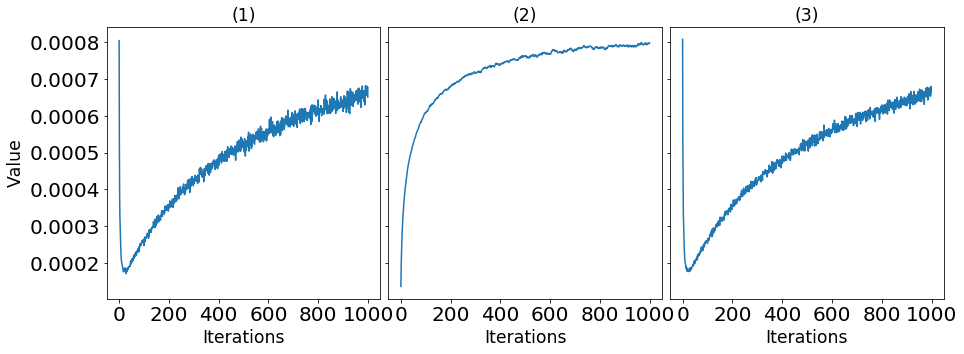

In [10]:
fig, ax = plt.subplots(1,3, figsize=(15,5), sharex=False, sharey='row')
temp = 1000
#ax[0, 0].plot(m[:temp, procs-1])
ax[0].plot(val_new[:temp, 0])
ax[1].plot(val_hat[:temp, 0])
ax[2].plot(val_hat_prime[:temp, 0])

# ax[0].set_title('\'m\' small batch sequential at k intervals')
# ax[1].set_title('\'m\' large batch default')
# ax[2].set_title('\'m\' large batch DistAdam')

ax[0].set_title('(1)', fontsize = 'xx-large')
ax[1].set_title('(2)', fontsize = 'xx-large')
ax[2].set_title('(3)', fontsize = 'xx-large')

ax1.set_xticks(np.arange(0, 1001, 100))

ax[0].set_xlabel('Iterations', fontsize = 'xx-large');
ax[1].set_xlabel('Iterations', fontsize = 'xx-large');
ax[2].set_xlabel('Iterations', fontsize = 'xx-large');

ax[0].set_ylabel('Value', fontsize = 'xx-large');
for axs in ax:
    for tick in axs.yaxis.get_major_ticks():
        tick.label.set_fontsize(20)
    for tick in axs.xaxis.get_major_ticks():
        tick.label.set_fontsize(20)
fig.subplots_adjust(wspace=0.03, hspace=0)

#fig.savefig('distadam_val.png')

In [13]:
'''
intermediate = m/(np.sqrt(v) + epsilon)
intermediate_hat = m_hat/(np.sqrt(v_hat) + epsilon)
intermediate_new = m_new/(np.sqrt(v_new) + epsilon)

fig, (ax1,ax2,ax3) = plt.subplots(1,3, figsize=(15,5), sharex=False, sharey=True)
temp=100
ax1.plot(intermediate[:temp, procs-1])
ax2.plot(intermediate_hat[:temp, 0])
ax3.plot(intermediate_new[:temp, 0])
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(15,5), sharex=False, sharey=True)
temp = 1000
ax1.plot(np.abs(m[:temp, procs-1] - m_new[:temp, 0]))
ax2.plot(np.abs(m[:temp, procs-1] - m_hat[:temp, 0]))
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(15,5), sharex=False, sharey=True)
temp = 1000
ax1.plot(np.abs(v[:temp, procs-1] - v_new[:temp, 0]))
ax2.plot(np.abs(v[:temp, procs-1] - v_hat[:temp, 0]))
fig, (ax1,ax2, ax3) = plt.subplots(3,1, figsize=(15,5), sharex=False, sharey=True)
temp = 2000
ax1.plot(v[:temp, procs-1])
ax2.plot(v_hat[:temp, 0])
ax3.plot(v_new[:temp, 0])

ax1.grid()
ax2.grid()
ax3.grid()
v[:temp, 0]/v_hat[:temp, 0]
fig, ax1 = plt.subplots(1,1, figsize=(10,10))
ax1.hist((np.sum(val, axis=1).reshape((-1,1))/val_hat), bins=100)
ax1.set_xticks(np.arange(-200, 200, step=20));
ax1.set_xlim(-200,200)
fig, (ax1, ax2) = plt.subplots(1,2)
ax1.plot(alpha)
ax2.plot(alpha_hat)
fig, (ax1, ax2) = plt.subplots(1,2)
ax1.plot(m[:256])
ax2.plot(m_hat)
fig, (ax1, ax2) = plt.subplots(1,2)
ax1.plot(v[:256])
ax2.plot(v_hat)
fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(15,5))
temp = procs*10
ax1.plot(np.ravel(val)[:temp])
ax2.plot(val_hat[:temp//procs, 0])
ax3.plot(val_new[:temp//procs, 0])

m
'''


'\nintermediate = m/(np.sqrt(v) + epsilon)\nintermediate_hat = m_hat/(np.sqrt(v_hat) + epsilon)\nintermediate_new = m_new/(np.sqrt(v_new) + epsilon)\n\nfig, (ax1,ax2,ax3) = plt.subplots(1,3, figsize=(15,5), sharex=False, sharey=True)\ntemp=100\nax1.plot(intermediate[:temp, procs-1])\nax2.plot(intermediate_hat[:temp, 0])\nax3.plot(intermediate_new[:temp, 0])\nfig, (ax1,ax2) = plt.subplots(1,2, figsize=(15,5), sharex=False, sharey=True)\ntemp = 1000\nax1.plot(np.abs(m[:temp, procs-1] - m_new[:temp, 0]))\nax2.plot(np.abs(m[:temp, procs-1] - m_hat[:temp, 0]))\nfig, (ax1,ax2) = plt.subplots(1,2, figsize=(15,5), sharex=False, sharey=True)\ntemp = 1000\nax1.plot(np.abs(v[:temp, procs-1] - v_new[:temp, 0]))\nax2.plot(np.abs(v[:temp, procs-1] - v_hat[:temp, 0]))\nfig, (ax1,ax2, ax3) = plt.subplots(3,1, figsize=(15,5), sharex=False, sharey=True)\ntemp = 2000\nax1.plot(v[:temp, procs-1])\nax2.plot(v_hat[:temp, 0])\nax3.plot(v_new[:temp, 0])\n\nax1.grid()\nax2.grid()\nax3.grid()\nv[:temp, 0]/v_hat